# Text Mining

# EXERCÍCIO AULA - Text Mining
Reproduza os Casos de Uso apresentados em https://scikit-network.readthedocs.io/en/latest/use_cases/text-mining.html

In [110]:
import numpy as np
import re
from sknetwork.data import convert_edge_list
from sknetwork.embedding import Spectral
from sknetwork.linalg import normalize

## LOAD DATA

In [111]:
filename = 'miserables-en.txt'
with open(filename, 'r') as f:
    text = f.read()

In [112]:
len(text)

3254333

In [113]:
print(text[:494])

﻿The Project Gutenberg EBook of Les Misérables, by Victor Hugo

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever. You may copy it, give it away or re-use
it under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org


Title: Les Misérables
       Complete in Five Volumes

Author: Victor Hugo

Translator: Isabel F. Hapgood

Release Date: June 22, 2008 [EBook #135]
Last Updated: January 18, 2016




## PRE-PROCESSING

In [114]:
# extract main text
main = text.split('LES MISÉRABLES')[-2].lower()

In [115]:
len(main)

3215017

In [116]:
# remove ponctuation
main = re.sub(r"[,.;:()@#?!&$'_*]", " ", main)
main = re.sub(r'["-]', ' ', main)

In [117]:
# extract paragraphs
sep = '|||'
main = re.sub(r'\n\n+', sep, main)
main = re.sub('\n', ' ', main)
paragraphs = main.split(sep)

In [118]:
len(paragraphs)

13499

In [119]:
paragraphs[1000]

'after leaving the asses there was a fresh delight  they crossed the seine in a boat  and proceeding from passy on foot they reached the barrier of l étoile  they had been up since five o clock that morning  as the reader will remember  but  bah  there is no such thing as fatigue on sunday   said favourite   on sunday fatigue does not work  '

## BUILD GRAPH

In [120]:
paragraph_words = [paragraph.split(' ') for paragraph in paragraphs]

In [121]:
graph = convert_edge_list(paragraph_words, bipartite=True)

In [122]:
biadjacency = graph.biadjacency

In [123]:
words = graph.names_col

In [124]:
biadjacency

<13499x23093 sparse matrix of type '<class 'numpy.int64'>'
	with 416331 stored elements in Compressed Sparse Row format>

In [125]:
len(words)

23093

## STATISTICS

In [126]:
n_row, n_col = biadjacency.shape

In [127]:
paragraph_lengths = biadjacency.dot(np.ones(n_col))

In [128]:
np.quantile(paragraph_lengths, [0.1, 0.5, 0.9, 0.99])

In [129]:
word_counts = biadjacency.T.dot(np.ones(n_row))

In [130]:
np.quantile(word_counts, [0.1, 0.5, 0.9, 0.99])

## EMBEDDING

In [131]:
dimension = 50
spectral = Spectral(dimension, regularization=100)

In [132]:
spectral.fit(biadjacency)

Spectral(n_components=50, decomposition='rw', regularization=100, normalized=True)

In [133]:
embedding_paragraph = spectral.embedding_row_
embedding_word = spectral.embedding_col_

In [134]:
# some word
i = int(np.argwhere(words == 'love'))

In [135]:
# most similar words
cosines_word = embedding_word.dot(embedding_word[i])
words[np.argsort(-cosines_word)[:20]]

In [136]:
np.quantile(cosines_word, [0.01, 0.1, 0.5, 0.9, 0.99])

In [137]:
# some paragraph
i = 1000
print(paragraphs[i])

after leaving the asses there was a fresh delight  they crossed the seine in a boat  and proceeding from passy on foot they reached the barrier of l étoile  they had been up since five o clock that morning  as the reader will remember  but  bah  there is no such thing as fatigue on sunday   said favourite   on sunday fatigue does not work  


In [138]:
# most similar paragraphs
cosines_paragraph = embedding_paragraph.dot(embedding_paragraph[i])
for j in np.argsort(-cosines_paragraph)[:3]:
    print(paragraphs[j])
    print()

after leaving the asses there was a fresh delight  they crossed the seine in a boat  and proceeding from passy on foot they reached the barrier of l étoile  they had been up since five o clock that morning  as the reader will remember  but  bah  there is no such thing as fatigue on sunday   said favourite   on sunday fatigue does not work  

he was a man of lofty stature  half peasant  half artisan  he wore a huge leather apron  which reached to his left shoulder  and which a hammer  a red handkerchief  a powder horn  and all sorts of objects which were upheld by the girdle  as in a pocket  caused to bulge out  he carried his head thrown backwards  his shirt  widely opened and turned back  displayed his bull neck  white and bare  he had thick eyelashes  enormous black whiskers  prominent eyes  the lower part of his face like a snout  and besides all this  that air of being on his own ground  which is indescribable 

this was the state which the shepherd idyl  begun at five o clock in t

In [139]:
np.quantile(cosines_paragraph, [0.01, 0.1, 0.5, 0.9, 0.99])

# Web graphs

# EXERCÍCIO AULA - WEB GRAPHS
Reproduza os Casos de Uso apresentados em https://scikit-network.readthedocs.io/en/latest/use_cases/web-graphs.html

In [140]:
from IPython.display import SVG
import numpy as np
from sknetwork.data import load_netset
from sknetwork.ranking import PageRank, top_k
from sknetwork.embedding import Spectral
from sknetwork.clustering import Louvain
from sknetwork.classification import DirichletClassifier
from sknetwork.utils import WardDense, get_neighbors
from sknetwork.visualization import svg_dendrogram

## Data

In [141]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [142]:
# graph of links
adjacency = wikivitals.adjacency
names = wikivitals.names
labels = wikivitals.labels
names_labels = wikivitals.names_labels

In [143]:
adjacency

<10011x10011 sparse matrix of type '<class 'numpy.bool_'>'
	with 824999 stored elements in Compressed Sparse Row format>

In [144]:
# categories
print(names_labels)

['Arts' 'Biological and health sciences' 'Everyday life' 'Geography'
 'History' 'Mathematics' 'People' 'Philosophy and religion'
 'Physical sciences' 'Society and social sciences' 'Technology']


In [145]:
# get label
label_id = {name: i for i, name in enumerate(names_labels)}

## Sample

In [146]:
i = 10000
print(names[i])

Édouard Manet


In [147]:
# label
label = labels[i]
print(names_labels[label])

People


In [148]:
# some hyperlinks
neighbors = get_neighbors(adjacency, i)
print(names[neighbors[:10]])

['Adolphe Thiers' 'American Civil War' 'Bordeaux' 'Camille Pissarro'
 'Carmen' 'Charles Baudelaire' 'Claude Monet' 'Diego Velázquez'
 'Edgar Allan Poe' 'Edgar Degas']


In [149]:
len(neighbors)

38

## Page

In [150]:
pagerank = PageRank()

In [151]:
# number of articles per category
n_selection = 50

In [152]:
# selection of articles
selection = []
for label in np.arange(len(names_labels)):
    ppr = pagerank.fit_transform(adjacency, seeds=(labels==label))
    scores = ppr * (labels==label)
    selection.append(top_k(scores, n_selection))
selection = np.array(selection)

In [153]:
selection.shape

(11, 50)

In [154]:
# show selection
for label, name_label in enumerate(names_labels):
    print('---')
    print(label, name_label)
    print(names[selection[label, :5]])

---
0 Arts
['Encyclopædia Britannica' 'Romanticism' 'Jazz' 'Modernism' 'Baroque']
---
1 Biological and health sciences
['Taxonomy (biology)' 'Animal' 'Chordate' 'Plant' 'Species']
---
2 Everyday life
['Olympic Games' 'Association football' 'Basketball' 'Baseball' 'Softball']
---
3 Geography
['Geographic coordinate system' 'United States' 'China' 'France' 'India']
---
4 History
['World War II' 'World War I' 'Roman Empire' 'Ottoman Empire'
 'Middle Ages']
---
5 Mathematics
['Real number' 'Function (mathematics)' 'Complex number'
 'Set (mathematics)' 'Integer']
---
6 People
['Aristotle' 'Plato' 'Augustine of Hippo' 'Winston Churchill'
 'Thomas Aquinas']
---
7 Philosophy and religion
['Christianity' 'Islam' 'Buddhism' 'Hinduism' 'Catholic Church']
---
8 Physical sciences
['Oxygen' 'Hydrogen' 'Earth' 'Kelvin' 'Density']
---
9 Society and social sciences
['The New York Times' 'Latin' 'English language' 'French language'
 'United Nations']
---
10 Technology
['NASA' 'Internet' 'Operating syste

## Embedding

In [155]:
# dimension of the embedding
n_components = 20

In [156]:
# embedding
spectral = Spectral(n_components)
embedding = spectral.fit_transform(adjacency)

In [157]:
embedding.shape

(10011, 20)

In [158]:
ward = WardDense()

In [159]:
# hierarchy of articles
label = label_id['Physical sciences']
index = selection[label]
dendrogram_articles = ward.fit_transform(embedding[index])

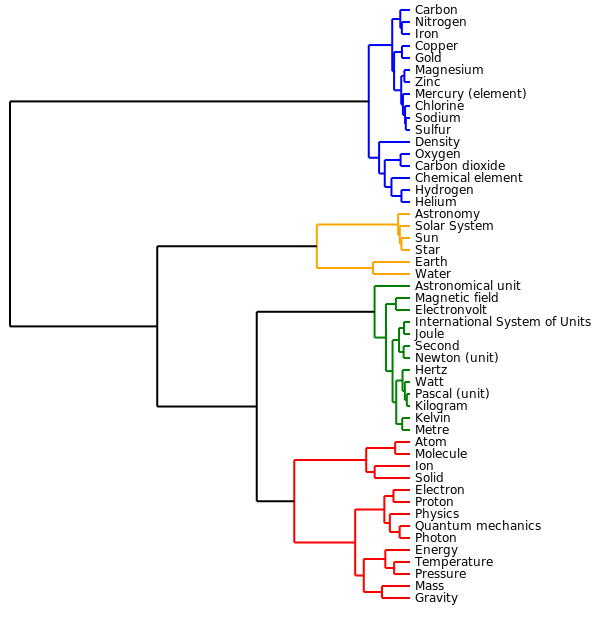

In [160]:
# visualization
image = svg_dendrogram(dendrogram_articles, names=names[index], rotate=True, width=200, scale=2, n_clusters=4)
SVG(image)

## Clustering

In [161]:
algo = Louvain()

In [162]:
labels_pred = algo.fit_transform(adjacency)

In [163]:
np.unique(labels_pred, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([1800, 1368, 1315, 1225, 1165, 1067,  804,  672,  468,   97,   30]))

In [164]:
n_selection = 5

In [165]:
selection = []
for label in np.arange(len(set(labels_pred))):
    ppr = pagerank.fit_transform(adjacency, seeds=(labels_pred==label))
    scores = ppr * (labels_pred==label)
    selection.append(top_k(scores, n_selection))
selection = np.array(selection)

## Classification

In [166]:
algo = DirichletClassifier()

In [167]:
people = label_id['People']

In [168]:
labels_people = algo.fit_transform(adjacency, seeds = {i: label for i, label in enumerate(labels) if label != people})

In [169]:
n_selection = 5

In [170]:
selection = []
for label in np.arange(len(names_labels)):
    if label != people:
        ppr = pagerank.fit_transform(adjacency, seeds=(labels==people)*(labels_people==label))
        scores = ppr * (labels==people)*(labels_people==label)
        selection.append(top_k(scores, n_selection))
selection = np.array(selection)

In [171]:
# show selection
i = 0
for label, name_label in enumerate(names_labels):
    if label != people:
        print('---')
        print(label, name_label)
        print(names[selection[i]])
        i += 1

---
0 Arts
['Richard Wagner' 'Igor Stravinsky' 'Bob Dylan' 'Fred Astaire'
 'Ludwig van Beethoven']
---
1 Biological and health sciences
['Charles Darwin' 'Francis Crick' 'Robert Koch' 'Alexander Fleming'
 'Carl Linnaeus']
---
2 Everyday life
['Wayne Gretzky' 'Jim Thorpe' 'Jackie Robinson' 'LeBron James'
 'Willie Mays']
---
3 Geography
['Elizabeth II' 'Carl Lewis' 'Dwight D. Eisenhower' 'Vladimir Putin'
 'Muhammad Ali']
---
4 History
['Alexander the Great' 'Napoleon' 'Charlemagne' 'Philip II of Spain'
 'Charles V, Holy Roman Emperor']
---
5 Mathematics
['Euclid' 'Augustin-Louis Cauchy' 'Archimedes' 'John von Neumann'
 'Pierre de Fermat']
---
7 Philosophy and religion
['Augustine of Hippo' 'Aristotle' 'Thomas Aquinas' 'Plato' 'Immanuel Kant']
---
8 Physical sciences
['Albert Einstein' 'Isaac Newton' 'J. J. Thomson' 'Marie Curie'
 'Niels Bohr']
---
9 Society and social sciences
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
---
10 Technology
['Tim Be

# Votes

# EXERCÍCIO AULA - Votes
Reproduza os Casos de Uso apresentados em https://scikit-network.readthedocs.io/en/latest/use_cases/votes.html

In [172]:
from IPython.display import SVG
import numpy as np
from sknetwork.data import load_netset
from sknetwork.clustering import Louvain
from sknetwork.ranking import Diffusion
from sknetwork.ranking import top_k, PageRank
from sknetwork.embedding import Spectral
from sknetwork.visualization import svg_graph, svg_dendrogram

## DATA

In [173]:
graph = load_netset('national_assembly')

Unpacking archive...
Parsing files...
Done.


In [174]:
biadjacency = graph.biadjacency
position = graph.position
names = graph.names_row
bills = graph.names_col
labels = graph.labels
label_colors = graph.label_colors
names_labels = graph.names_labels

In [175]:
n_deputy, n_bill = biadjacency.shape

In [176]:
print(names_labels)

['Non inscrit' 'Les Républicains'
 'Les Constructifs : républicains, UDI, indépendants'
 'Libertés et Territoires' 'UDI et Indépendants'
 'UDI, Agir et Indépendants' 'Mouvement Démocrate et apparentés'
 'La République en Marche' 'Socialistes et apparentés' 'Nouvelle Gauche'
 'Gauche démocrate et républicaine' 'La France insoumise']


In [177]:
# parameters for visualization
node_size = 4
width = 480
height = 300

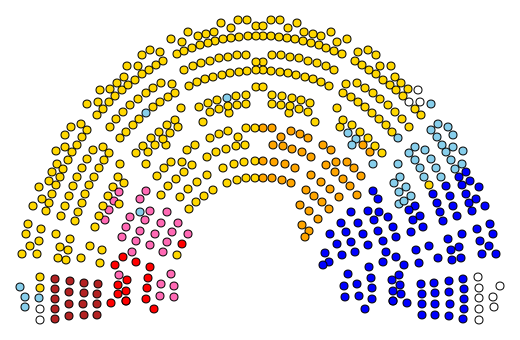

In [178]:
image = svg_graph(position=position, labels=labels, node_size=node_size, width=width, height=height,
                  label_colors=label_colors)
SVG(image)

In [179]:
labels_majority = [6,7]

In [180]:
print(names_labels[labels_majority])

['Mouvement Démocrate et apparentés' 'La République en Marche']


In [181]:
# majority
majority = np.isin(labels, labels_majority)
np.sum(majority)

356

In [182]:
# opposition
opposition = ~np.isin(labels, labels_majority)
len(opposition)

577

## VOTES

In [183]:
biadjacency_for = biadjacency > 0
biadjacency_against = (-biadjacency > 0)

In [184]:
biadjacency_for

<577x2807 sparse matrix of type '<class 'numpy.bool_'>'
	with 119901 stored elements in Compressed Sparse Row format>

In [185]:
bills_for = biadjacency_for.T.dot(np.ones(n_deputy))
bills_against = biadjacency_against.T.dot(np.ones(n_deputy))
bills_total = bills_for + bills_against

In [186]:
print('Average participation = ', np.round(np.sum(bills_total) / n_bill / n_deputy, 2))

Average participation =  0.17


## CLUSTERING

In [187]:
louvain = Louvain()

In [188]:
labels_pred = louvain.fit_transform(biadjacency_for)

In [189]:
np.unique(labels_pred, return_counts=True)

(array([0, 1, 2]), array([213, 363,   1]))

In [190]:
labels_pred_majority, counts_majority = np.unique(labels_pred[majority], return_counts=True)

In [191]:
label_pred_majority = labels_pred_majority[np.argmax(counts_majority)]

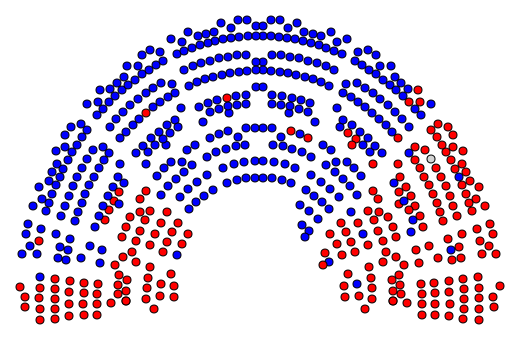

In [192]:
image = svg_graph(position=position, labels=labels_pred, node_size=node_size, width=width, height=height, label_colors=['red','blue', 'lightgrey'])
SVG(image)

In [193]:
neutral = np.argwhere(labels_pred==2).ravel()

In [194]:
print(names[neutral])

['Laure de La Raudière']


In [195]:
# dissident
print(names[majority * (labels_pred!=label_pred_majority)])

['Frédérique Dumas' 'Maud Petit' 'Sonia Krimi' 'Richard Ramos'
 'Sébastien Nadot']


## DIFUSSION

In [196]:
diffusion = Diffusion(n_iter=4)

In [197]:
scores = diffusion.fit_transform(biadjacency_for, seeds_row=majority)

In [198]:
np.quantile(scores, [0.1, 0.5, 0.9])

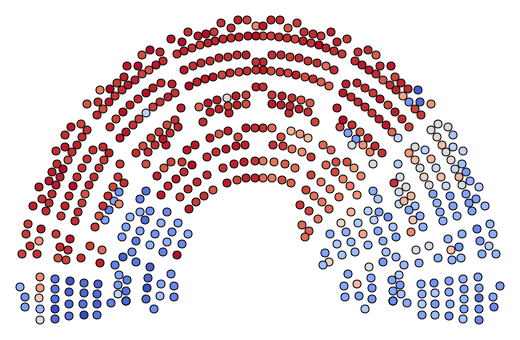

In [199]:
image = svg_graph(position=position, scores=scores, node_size=node_size,
                  width=width, height=height)
SVG(image)

In [200]:
# top-10 deputies for majority
index = np.argwhere(majority).ravel()
top = index[top_k(scores[index], 10)]
print(names[top])

['Émilie Chalas' 'Didier Paris' 'Richard Ferrand'
 'Élise Fajgeles|||Benjamin Griveaux' 'Guillaume Vuilletet'
 'Yaël Braun-Pivet' 'Marie Guévenoux' 'Jean Terlier' 'Sacha Houlié'
 'Thomas Rudigoz']


In [201]:
# bottom-10 deputies for majority
bottom = index[top_k(-scores[index], 10)]
print(names[bottom])

['Frédérique Dumas' 'Maud Petit' 'Richard Ramos' 'Agnès Thill'
 'Brahim Hammouche' 'Sébastien Nadot' 'Jimmy Pahun' 'Josy Poueyto'
 'Sonia Krimi' 'Max Mathiasin']


In [202]:
# top-10 deputies for opposition
index = np.argwhere(opposition).ravel()
top = index[top_k(-scores[index], 10)]
print(names[top])

['Ugo Bernalicis' 'Adrien Quatennens' 'Alain Bruneel' 'Clémentine Autain'
 'Nicolas Dupont-Aignan' 'Alexis Corbière' 'Jean-Luc Mélenchon'
 'Sébastien Jumel' 'Jean-Hugues Ratenon' 'Pierre Dharréville']


In [203]:
# bottom-10 deputies for opposition
bottom = index[top_k(scores[index], 10)]
print(names[bottom])

['Jean-Luc Warsmann' 'Olivier Dassault' 'Napole Polutele|||Sylvain Brial'
 'Stéphane Demilly' 'Michèle Tabarot' 'Bernard Deflesselles'
 'Franck Riester|||Patricia Lemoine' 'Thierry Robert|||Jean-Luc Poudroux'
 'Laure de La Raudière' 'Philippe Gomès']


## BILLS

In [204]:
# labels are on deputies so you need an odd number of iterations
diffusion = Diffusion(n_iter=5)

In [205]:
diffusion.fit(biadjacency_for, seeds_row=majority)

Diffusion(n_iter=5, damping_factor=1.0)

In [206]:
scores_bill = diffusion.scores_col_

In [207]:
np.quantile(scores_bill, [0.1, 0.5, 0.9])

In [208]:
# top-5 bills for majority
for i in top_k(scores_bill, 5):
    print(bills[i] + '\n')

l'article 27 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).

l'amendement de suppression n° 72 du Gouvernement à l'article 9 de la proposition de loi d'orientation et de programmation relative à la sécurité intérieure (première lecture).

l'amendement de suppression n° 71 du Gouvernement à l'article 3 de la proposition de loi d'orientation et de programmation relative à la sécurité intérieure (première lecture).

l'amendement n° 2362  de Mme Marsaud après l'article 60 du projet de loi portant évolution du logement, de l'aménagement et du numérique (première lecture)

l'article 13 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).



In [209]:
# top-5 bills for opposition
for i in top_k(-scores_bill, 5):
    print(bills[i] + '\n')

l'amendement n° 602 de M. Bernalicis à l'article 32 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).

l'amendement n° 208 de Mme Obono après l'article 31 bis du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).

l'amendement n° 205 de Mme Obono après l'article 30 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).

l'amendement n° 11 de M. Bernalicis à l'article unique de la proposition de loi renforçant la lutte contre les rodéos motorisés (première lecture).

l'amendement n° 272 de Mme Obono à l'article 50 du projet de loi de programmation 2018-2022 et de réforme pour la justice (première lecture).



In [210]:
# top-5 controversial
for i in top_k(-np.abs(scores_bill-0.5), 5):
    print(bills[i] + '\n')

l'article unique de la proposition de loi organique visant à permettre l'inscription d'office sur la liste électorale spéciale à la consultation sur l'accession à la pleine souveraineté de la Nouvelle-Calédonie (première lecture).

l'amendement n° 66 de Mme Auconie et les amendements identiques suivants à l'article premier du projet de loi renforçant la lutte contre les violences sexuelles et sexistes (première lecture).

l'amendement de suppression n° 168 de Mme Obono et les amendements identiques suivants à l'article 9 ter du projet de loi pour une immigration maîtrisée, un droit d'asile effectif et une intégration réussie (nouvelle lecture).

l'amendement n° 962 de la commission du développement durable et l'amendement identique suivant après l'article 14 septies du projet de loi pour l'équilibre des relations commerciales dans le secteur agricole et alimentaire et une alimentation saine et durable (première lecture).

l'amendement n° 1118 de M. Clément à l'article premier du projet

## Embedding

In [211]:
spectral = Spectral(2, normalized=False)

In [212]:
embedding = spectral.fit_transform(biadjacency_for)

In [213]:
image = svg_graph(position=embedding, names=names, labels=labels, node_size=5, width=400, height=1000,
                  label_colors=label_colors)

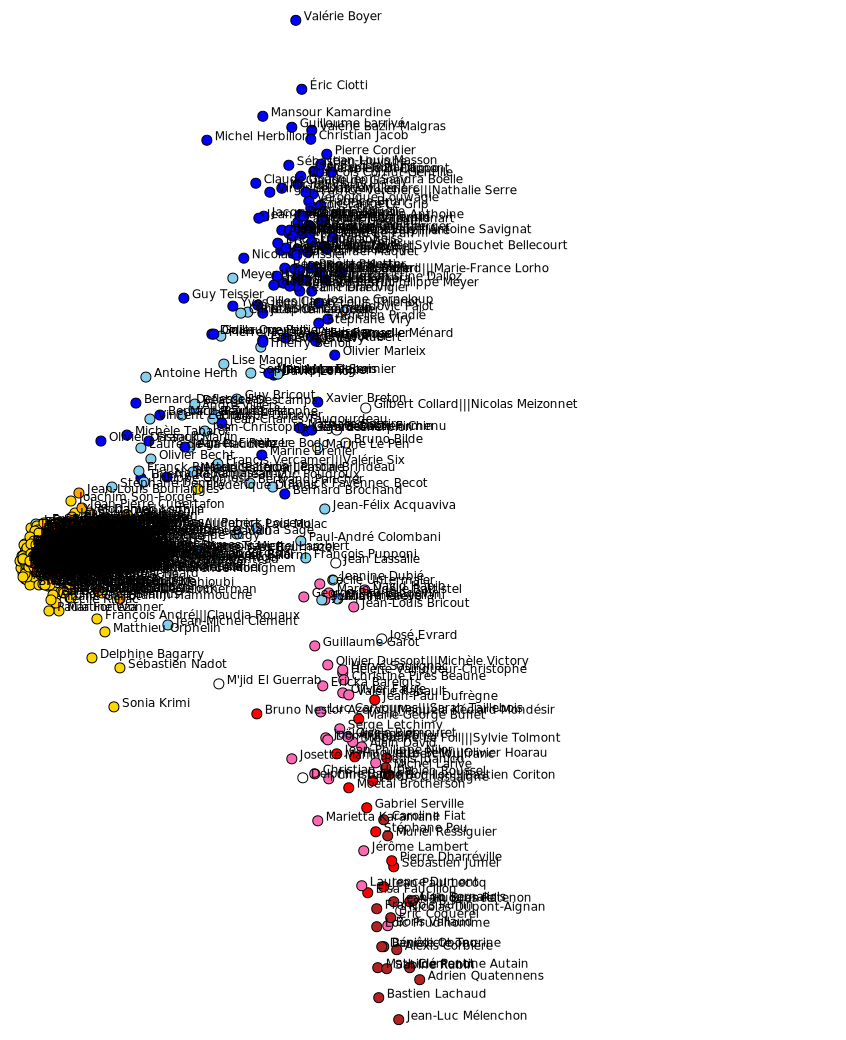

In [214]:
SVG(image)

# Sports

# EXERCÍCIO AULA - Sports
Reproduza os Casos de Uso apresentados em https://scikit-network.readthedocs.io/en/latest/use_cases/sport.html

In [215]:
from IPython.display import SVG

In [216]:
import numpy as np
import pandas as pd
from scipy import sparse

In [217]:
from sknetwork.data import convert_edge_list
from sknetwork.ranking import PageRank, top_k
from sknetwork.topology import CoreDecomposition
from sknetwork.utils import directed2undirected
from sknetwork.embedding import Spectral
from sknetwork.visualization import svg_digraph, svg_graph

## Load Data

In [218]:
filename = 'atp.csv'

In [219]:
df = pd.read_csv(filename, sep=';')

In [220]:
df.head

<bound method NDFrame.head of        ATP     Location                           Tournament        Date  \
0       25      Houston  U.S. Men's Clay Court Championships  2005-04-21   
1       26      Estoril                         Estoril Open  2005-04-27   
2       28         Rome          Telecom Italia Masters Roma  2005-05-03   
3       28         Rome          Telecom Italia Masters Roma  2005-05-04   
4       29      Hamburg                          Hamburg TMS  2005-05-11   
...    ...          ...                                  ...         ...   
44060   43    Kitzbuhel                        Generali Open  2002-07-22   
44061   44  Los Angeles                    Mercedes-Benz Cup  2002-07-22   
44062   45        Sopot                     Idea Prokom Open  2002-07-22   
44063   46      Toronto                          Toronto TMS  2002-07-29   
44064   46      Toronto                          Toronto TMS  2002-07-29   

                     Series    Court Surface      Round  

In [221]:
df = df[df['Comment']=='Completed']

In [222]:
len(df)

42261

## Build graph

In [223]:
edge_list = list(df[['Winner', 'Loser']].itertuples(index=False, name=None))

In [224]:
len(edge_list)

42261

In [225]:
graph = convert_edge_list(edge_list, directed=True)

In [226]:
adjacency = graph.adjacency
names = graph.names

In [227]:
adjacency

<1255x1255 sparse matrix of type '<class 'numpy.int64'>'
	with 28212 stored elements in Compressed Sparse Row format>

In [228]:
len(names)

1255

## Ranking

In [229]:
# top-10 players in number of wins
out_weights = adjacency.dot(np.ones(len(names)))
print(names[top_k(out_weights, 10)])

['Federer R.' 'Nadal R.' 'Djokovic N.' 'Ferrer D.' 'Murray A.'
 'Roddick A.' 'Berdych T.' 'Robredo T.' 'Davydenko N.' 'Hewitt L.']


In [230]:
# top-10 players in terms of PageRank
pagerank = PageRank()
adjacency_transpose = sparse.csr_matrix(adjacency.T)
scores = pagerank.fit_transform(adjacency_transpose)
print(names[top_k(scores, 10)])

['Federer R.' 'Nadal R.' 'Djokovic N.' 'Murray A.' 'Ferrer D.'
 'Roddick A.' 'Berdych T.' 'Hewitt L.' 'Davydenko N.' 'Wawrinka S.']


In [231]:
index = top_k(scores, 10)
sub_adjacency = adjacency[index][:, index]

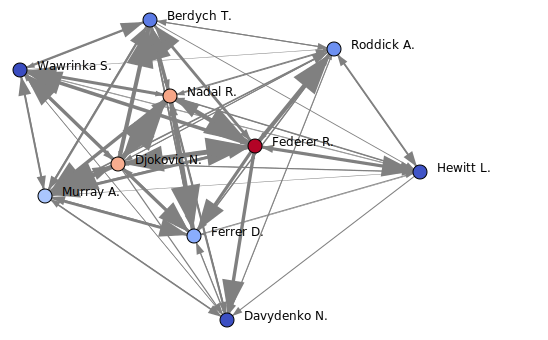

In [232]:
SVG(svg_digraph(sub_adjacency, names=names[index], scores=scores[index]))

## Core decomposition

In [233]:
algo = CoreDecomposition()

In [234]:
adjacency_sym = directed2undirected(adjacency)

In [235]:
labels = algo.fit_transform(adjacency_sym)

In [236]:
print(names[labels == algo.core_value_])

['Acasuso J.' 'Almagro N.' 'Ancic M.' 'Anderson K.' 'Andreev I.'
 'Andujar P.' 'Baghdatis M.' 'Beck K.' 'Becker B.' 'Bellucci T.'
 'Benneteau J.' 'Berdych T.' 'Berlocq C.' 'Berrer M.' 'Bjorkman J.'
 'Blake J.' 'Bolelli S.' 'Calleri A.' 'Canas G.' 'Chardy J.' 'Chela J.I.'
 'Cilic M.' 'Clement A.' 'Coria G.' 'Cuevas P.' 'Darcis S.' 'Davydenko N.'
 'Del Potro J.M.' 'Dent T.' 'Dimitrov G.' 'Djokovic N.' 'Dodig I.'
 'Dolgopolov O.' 'Falla A.' 'Federer R.' 'Ferrer D.' 'Ferrero J.C.'
 'Fish M.' 'Fognini F.' 'Gabashvili T.' 'Garcia-Lopez G.' 'Gasquet R.'
 'Gaudio G.' 'Gicquel M.' 'Gimeno-Traver D.' 'Ginepri R.' 'Giraldo S.'
 'Golubev A.' 'Gonzalez F.' 'Granollers M.' 'Grosjean S.' 'Gulbis E.'
 'Haas T.' 'Haase R.' 'Hanescu V.' 'Harrison R.' 'Henman T.' 'Hernych J.'
 'Hewitt L.' 'Horna L.' 'Hrbaty D.' 'Isner J.' 'Istomin D.' 'Johansson T.'
 'Karlovic I.' 'Kiefer N.' 'Kohlschreiber P.' 'Korolev E.' 'Koubek S.'
 'Kubot L.' 'Kunitsyn I.' 'Lapentti N.' 'Lee H.T.' 'Ljubicic I.'
 'Llodra M.' 'Lopez F

## Embedding

In [237]:
spectral = Spectral(2, normalized=False)

In [238]:
embedding = spectral.fit_transform(adjacency)

In [239]:
index = np.argwhere(labels == algo.core_value_).ravel()

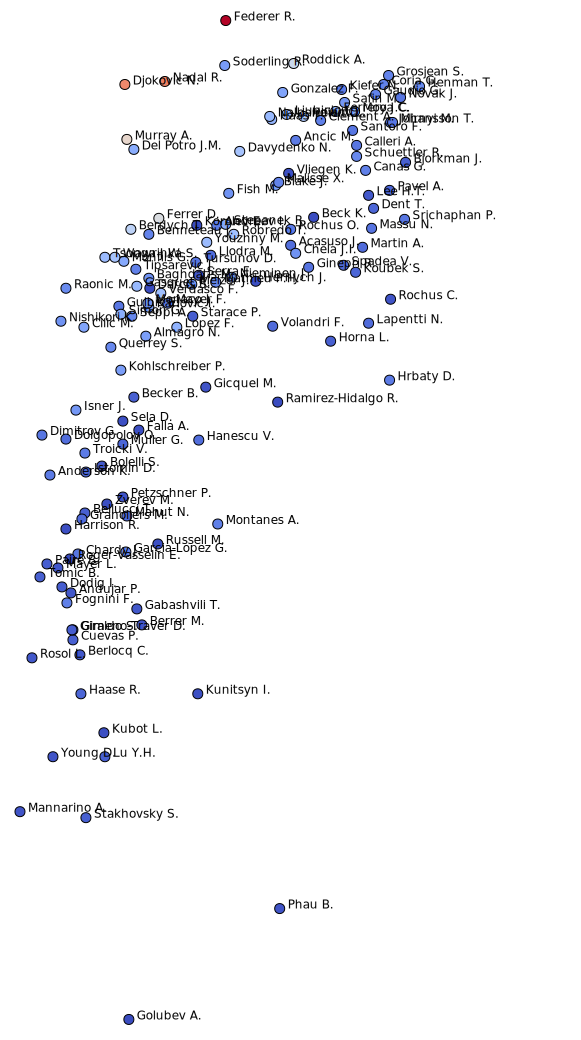

In [240]:
SVG(svg_graph(position=embedding[index], names=names[index], scores=scores[index], node_size=5, width=400, height=1000))